# Annotating Step-Annotated Videos using CVAT and FiftyOne

## Basic annotation workflow:

#### The critical piece of the puzzle for efficient annotation is: **we don't need to annotate every frame.** 
We can find ways to interpolate annotations automatically.

Tools at your disposal:
 - **FiftyOne:** dataset visualization and management tool. Use this so you don't have to worry about dataset formats and loading things into CVAT.
 - **CVAT**: An image/video annotation tool.
    - **Segment Anything**: A model that interactively takes user clicks and gives segmentation maps. It's embedded into CVAT as an extension.
 - **Detic**: A zero-shot object detector that uses text prompts. 
 - **XMem**: A zero-shot object tracker that can track objects given a segmentation map.

Goals:
 - Annotate object segmentations (not manually drawn)
    - Object tracks: Each object should have a track ID through the 

There's a few possible pipelines:
 - Fully automatic: Detic with reduced vocab -> XMem
 - Semi-automatic: CVAT+Segment Anything -> XMem
 - Mixed: CVAT+Segment Anything | Merge with Detic -> XMem
 - Bulk Annotation: Detic -> XMem -> Sample a few examples from each XMem track -> Use FiftyOne embedding viewer to label in the embedding space.

### Annotation pipeline (see below)
 1. Load video dataset with step annotations
 2. Use step annotations to mark start and end as keyframes. 
 3. Annotate minimal number of frames where objects change
 4. Save dataset
 5. run xmem script and write annotations to file
 6. load videos with xmem annotations
 7. verify quality
 8. export to (... COCO?)

## CVAT Setup

```python
# download CVAT
git clone https://github.com/TaSeeMba/cvat.git
cd cvat

# Deploy CVAT and all of its containers
CVAT_HOST=localhost docker compose -f docker-compose.yml -f components/serverless/docker-compose.serverless.yml up -d

# Deploy Segment Anything
./serverless/deploy_gpu.sh serverless/pytorch/facebookresearch/sam/nuclio/
```

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install pathtrees fiftyone supervision tqdm opencv-python pandas torch torchvision
# !git clone ... && pip install -e ./XMem

In [3]:
import fiftyone as fo
import fiftyone.utils.video
import fiftyone.zoo as foz

In [4]:
import os
import pathtrees as pt
import sys, logging
logging.basicConfig(stream=sys.stdout)

import cv2
import tqdm
import numpy as np
import pandas as pd
import torch
# from PIL import Image
import supervision as sv
from torchvision.transforms import functional as F
from torchvision.ops import masks_to_boxes
from xmem.inference import XMem, log as xmlog
from xmem.inference.interact.interactive_utils import image_to_torch

xmlog.setLevel(logging.INFO)

In [5]:
def xyxy2xywhn(xyxy, shape):
    xyxy[..., 2:] -= xyxy[..., :2]
    xyxy = xyxy / torch.as_tensor(shape[:2][::-1]*2, device=xyxy.device)
    return xyxy

In [6]:
torch.no_grad().__enter__()

In [7]:
device = 'cuda' # 
xmem = XMem({}).eval().to(device)

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False


In [8]:
from detic import Detic
detic = Detic(['tortilla'], masks=True).eval().cuda()

/home/bea/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading pretrained CLIP
https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth


/home/bea/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Load Dataset with step Annotations

In [9]:
vocabularies = {
    'pinwheels': [
        'tortilla',
        'plate',
        'knife',
        # 'cutting board',
        # 'peanut butter jar',
        # 'jelly jar',
    ],
    'quesadilla': [
        'tortilla',
        'plate',
        'knife',
        'cutting board',
        # 'cinnamon',
        # 'banana',
    ],
    'oatmeal': [
        'bowl',
        'microwave',
        'oats container',
        'honey',
        # 'cinnamon',
    ],
    'coffee': [
        'mug',
        'measuring cup',
        'coffee beans',
        # 'coffee grounds',
        'scale',
    ],
    'tea': [
        'mug',
        'tea bag',
        'spoon',
        'honey',
    ],
}

In [10]:
skill_name = 'pinwheels'

cvat_url = "http://localhost:8080"
dataset_name = skill_name
anno_key = "cvat51"

video_pattern = '/datasets/Milly/data/A*_pv.mp4'
steps_csv = '/datasets/Milly_full.csv'
video_proc_dir = '/datasets/Milly_proc'

# label_field = "ground_truth"
label_field = "frames.ground_truth"
classes = vocabularies[skill_name]

In [11]:
# TODO load correct dataset

# load the dataset
# dataset = foz.load_zoo_dataset("quickstart-video", dataset_name=dataset_name)
dataset = fo.Dataset.from_videos_patt(video_pattern, name=dataset_name, overwrite=True)
ogview = view = dataset.view()
view
# dataset.persistent = True

 100% |█████████████████| 129/129 [37.8ms elapsed, 0s remaining, 3.4K samples/s]   
INFO:eta.core.utils: 100% |█████████████████| 129/129 [37.8ms elapsed, 0s remaining, 3.4K samples/s]   


Dataset:     pinwheels
Media type:  video
Num samples: 129
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
Frame fields:
    id:           fiftyone.core.fields.ObjectIdField
    frame_number: fiftyone.core.fields.FrameNumberField
View stages:
    ---

In [12]:
# session = fo.launch_app(view=view)
# session

### Add step annotations

In [13]:
steps_df = pd.read_csv(steps_csv)
steps_df.head()

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes,split
0,0,R0-P00,R0-P00_00,00:00:00.000,00:00:00.000,00:00:00.000,0,148,0. start.,0. start.,0,0. start.,0,['0. start.'],[0],train
1,1,R0-P00,R0-P00_00,00:00:00.000,00:00:00.000,00:00:00.000,149,1329,2. Use a butter knife to scoop nut butter from...,2. Use a butter knife to scoop nut butter from...,3,2. Use a butter knife to scoop nut butter from...,3,['2. Use a butter knife to scoop nut butter fr...,[3],train
2,2,R0-P00,R0-P00_00,00:00:00.000,00:00:00.000,00:00:00.000,1330,1423,3. Clean the knife by wiping with a paper towel.,3. Clean the knife by wiping with a paper towel.,4,3. Clean the knife by wiping with a paper towel.,4,['3. Clean the knife by wiping with a paper to...,[4],train
3,3,R0-P00,R0-P00_00,00:00:00.000,00:00:00.000,00:00:00.000,1424,2060,4. Use the knife to scoop jelly from the jar. ...,4. Use the knife to scoop jelly from the jar. ...,5,4. Use the knife to scoop jelly from the jar. ...,5,['4. Use the knife to scoop jelly from the jar...,[5],train
4,4,R0-P00,R0-P00_00,00:00:00.000,00:00:00.000,00:00:00.000,2061,2137,5. Clean the knife by wiping with a paper towel.,5. Clean the knife by wiping with a paper towel.,6,5. Clean the knife by wiping with a paper towel.,6,['5. Clean the knife by wiping with a paper to...,[6],train


In [14]:
def fname_to_video_id(fname):
    # translate filename to recipe ID
    video_id = os.path.basename(fname)
    try:
        pdata = pathn.parse(video_id)
        pdata['rid'] = ord(pdata['key'].upper()) - 65
    except ValueError:
        import traceback
        traceback.print_exc()
        return
    video_id = 'R{rid}-P{part_id:02d}_{vid_id:02d}'.format(**pdata)
    return video_id

pathn = pt.Path('{key}_{skill}_{medium}_{part_id:d}_video-{vid_id:04d}_{cam}.mp4')
for d in tqdm.tqdm(view):
    video_id = fname_to_video_id(d.filepath)
    if not video_id: 
        continue

    # add steps
    sdf = steps_df[steps_df.video_id == video_id]
    d["steps"] = fo.TemporalDetections(
        detections=[
            fo.TemporalDetection(label=row.narration, support=[int(row.start_frame)+1, int(row.stop_frame)+1])
            for _, row in sdf.iterrows()
        ]
    )
    d.save()

100%|██████████| 129/129 [00:00<00:00, 252.07it/s]


## Use step annotations to mark keyframes

In [15]:
# TODO does this work? how do we

In [16]:
view = ogview.take(1)
view

Dataset:     pinwheels
Media type:  video
Num samples: 1
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    steps:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.TemporalDetections)
Frame fields:
    id:           fiftyone.core.fields.ObjectIdField
    frame_number: fiftyone.core.fields.FrameNumberField
View stages:
    1. Take(size=1, seed=None)

In [17]:
# # Mark some keyframes
# sample = view.first()
# num_frames = len(sample.frames)
# keyframes = set(range(1, num_frames, 10)) | {1, num_frames}
# for frame_number in keyframes:
#     frame = sample.frames[frame_number]
#     for det in frame.detections.detections:
#         det.keyframe = True

# sample.save()

In [18]:
session = fo.launch_app(view=view)
session

Dataset:          pinwheels
Media type:       video
Num samples:      1
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/
View stages:
    1. Take(size=1, seed=None)

In [19]:
# takes a little bit, but
# fiftyone.utils.video.reencode_videos(view)

 100% |█████████████████████| 1/1 [53.5s elapsed, 0s remaining, 0.0 samples/s] 
INFO:eta.core.utils: 100% |█████████████████████| 1/1 [53.5s elapsed, 0s remaining, 0.0 samples/s] 


In [20]:
session.view = view


Could not connect session, trying again in 10 seconds



DoesNotExist: Document does not exist


Could not connect session, trying again in 10 seconds



In [71]:
# session.view = view

## Add Detic detections

FOR SOME REASON THIS HAS TO BE RUN AFTER `view.annotate(...)`

In [100]:
detic.set_vocab([
    'tortilla, white, circular',
    'knife',
    'person',
    'plate',
    # 'cutting board',
    # 'mug cup',
    # 'liquid measuring cup',
    # 'coffee beans',
    # # 'coffee grounds',
    # 'electric kitchen scale',
])

In [82]:
def detectron_to_fo(outputs, shape):
    # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    detections = []
    instances = outputs["instances"].to("cpu")
    for xyxy, score, c, mask in zip(
        instances.pred_boxes, # top-left, bottom-right xyxy
        instances.scores, # confidences
        instances.pred_classes, # class_ids
        instances.pred_masks  # segmentation masks (binary masks)
    ):
        x1, y1, x2, y2 = xyxy
        fo_mask = mask.numpy()[int(y1):int(y2), int(x1):int(x2)]
        detection = fo.Detection(
            label=detic.labels[c], 
            confidence=float(score), 
            bounding_box=xyxy2xywhn(xyxy, shape), 
            mask=fo_mask)
        detections.append(detection)
    return fo.Detections(detections=detections)



for video_sample in view:
    # load and iterate the video
    video_path = video_sample.filepath
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    ogfps = video_info.fps
    for i, frame in tqdm.tqdm(
        enumerate(sv.get_video_frames_generator(video_path), 1), 
        total=video_info.total_frames,
        desc=video_path,
    ):
        if i % 3: continue
        output = detic(frame)
        finfo = video_sample.frames[i]
        finfo['detections'] = detectron_to_fo(output, frame.shape)
        finfo.save()

/datasets/Milly_proc/A_pin_mevo_18_video-0012_pv.mp4: 100%|██████████| 3702/3702 [02:06<00:00, 29.37it/s]


## Annotate dataset

1. Click interact -> 
2. Be sure to set "Convert masks to polylines"
2. 

In [101]:
# massively reduce data transfer #max_fps=6, 
fo.utils.video.transform_videos(view, max_size=(720, -1), reencode=True, output_dir=video_proc_dir)

 100% |█████████████████████| 1/1 [18.8s elapsed, 0s remaining, 0.1 samples/s] 
INFO:eta.core.utils: 100% |█████████████████████| 1/1 [18.8s elapsed, 0s remaining, 0.1 samples/s] 


In [102]:
if dataset.has_annotation_run(anno_key):
    input()
    dataset.delete_annotation_run(anno_key)
anno_results = view.annotate(
    anno_key, 
    label_field=label_field,
    label_type='detections',
    classes=classes,
    attributes=[],
    launch_editor=True,
    url=cvat_url)
# dataset.get_annotation_info(anno_key)

Please enter your login credentials.
You can avoid this in the future by setting your `FIFTYONE_CVAT_USERNAME` and `FIFTYONE_CVAT_PASSWORD` environment variables
INFO:fiftyone.utils.annotations:Please enter your login credentials.
You can avoid this in the future by setting your `FIFTYONE_CVAT_USERNAME` and `FIFTYONE_CVAT_PASSWORD` environment variables
Computing metadata...
INFO:fiftyone.core.metadata:Computing metadata...
 100% |█████████████████████| 1/1 [1.3s elapsed, 0s remaining, 0.8 samples/s] 
INFO:eta.core.utils: 100% |█████████████████████| 1/1 [1.3s elapsed, 0s remaining, 0.8 samples/s] 
Uploading samples to CVAT...
INFO:fiftyone.utils.cvat:Uploading samples to CVAT...
Launching editor at 'http://localhost:8080/tasks/152/jobs/152'...
INFO:fiftyone.utils.cvat:Launching editor at 'http://localhost:8080/tasks/152/jobs/152'...


In [40]:
# anno_results.print_status()

### Load annotations back into app and cleanup

In [103]:
view.load_annotations(anno_key)
# view.load_annotations(anno_key, cleanup=True)

INFO:fiftyone.utils.cvat:Downloading labels from CVAT...
Download complete
INFO:fiftyone.utils.cvat:Download complete
Loading labels for field 'frames.ground_truth'...
INFO:fiftyone.utils.annotations:Loading labels for field 'frames.ground_truth'...
 100% |█████████████████████| 1/1 [1.5s elapsed, 0s remaining, 0.7 samples/s] 
INFO:eta.core.utils: 100% |█████████████████████| 1/1 [1.5s elapsed, 0s remaining, 0.7 samples/s] 


In [42]:
# for d in view:
#     for i in d.frames:
#         t = d.frames[i].ground_truth
#         if t is not None:
#             print(i, t)
#     break


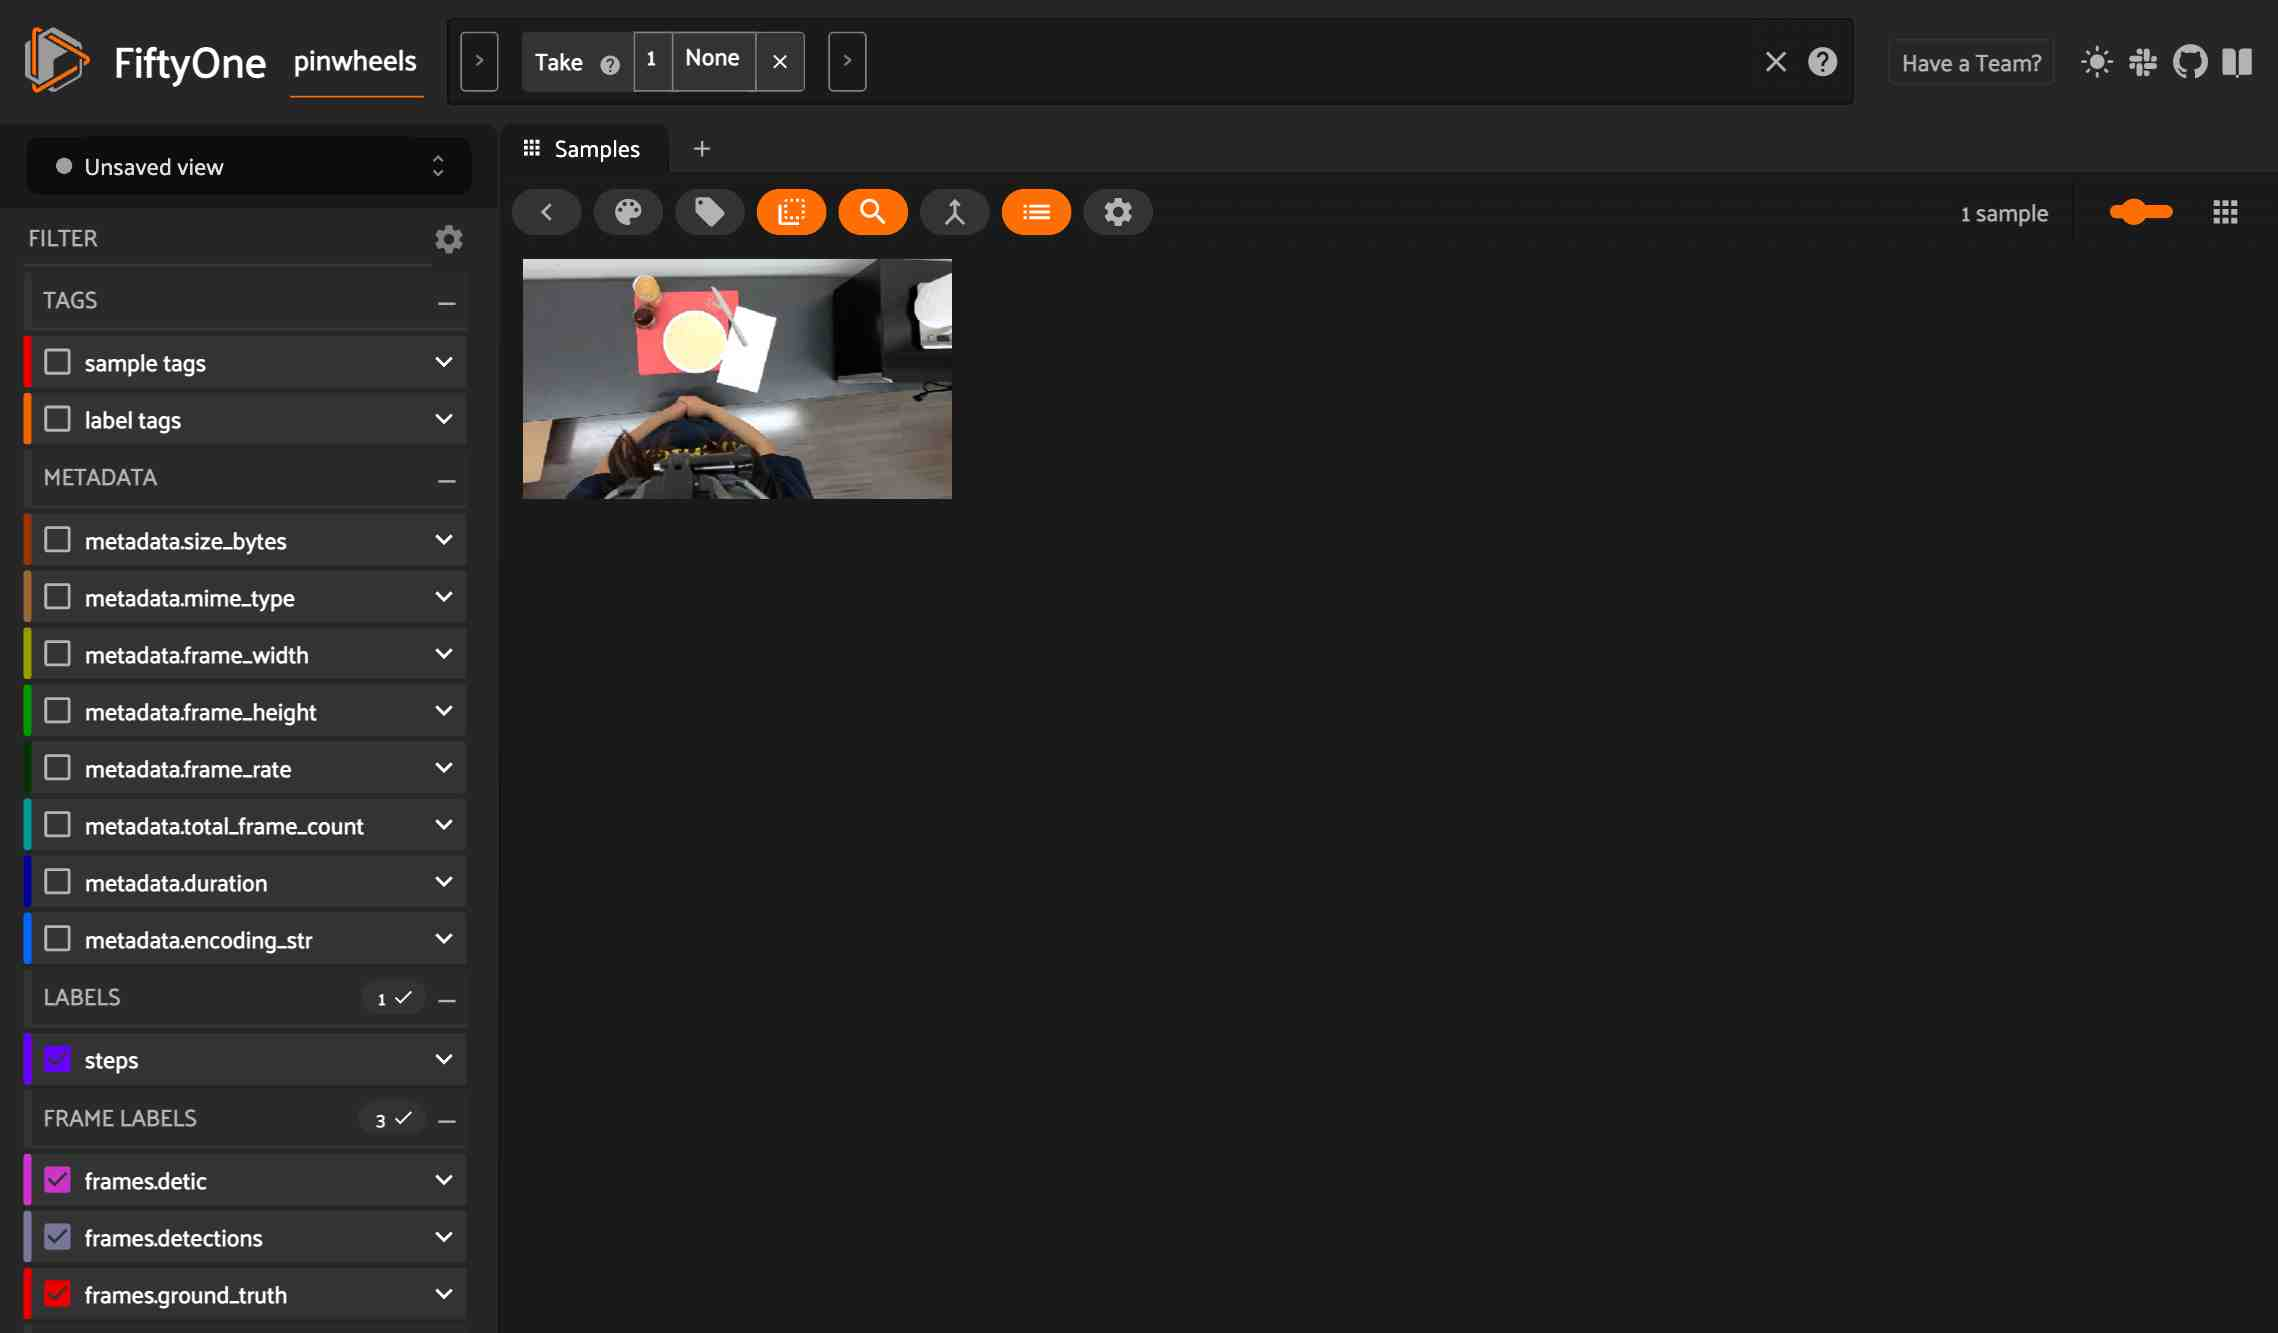

In [43]:

session.view = view

## Run XMem over annotations

In [104]:
def detection2mask(d, orig_shape, new_shape):
    # the mask of a detection object is relative to the bounding box
    # convert to segmentation object
    return torch.as_tensor(cv2.resize(d.to_segmentation(frame_size=orig_shape, target=1).mask, new_shape))

def mask2detection(mask):
    # the mask of a detection object needs to be relative to the bounding box
    # convert to segmentation object
    return fo.Segmentation(mask=mask.cpu().numpy()).to_detections().detections[0]

In [105]:
# video_sample

In [106]:
# cview = view.clone()
# cview.compute_metadata(overwrite=True)

In [107]:
xmem.clear_memory(reset_index=True)

W = 240

field = 'ground_truth'
# field = 'detections'

cview = view.clone()
cview.compute_metadata(overwrite=True)
for video_sample, v2 in tqdm.tqdm(zip(view, cview)):
    # store the last track detection object so we can copy it
    track_detections = {}

    fps = v2.metadata.frame_rate
    wd = v2.metadata.frame_width
    hd = v2.metadata.frame_height

    # load and iterate the video
    video_path = video_sample.filepath
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    ogfps = video_info.fps
    for i, frame in tqdm.tqdm(
        enumerate(sv.get_video_frames_generator(video_path), 1), 
        total=video_info.total_frames,
        desc=video_path,
    ):
        ho, wo = frame.shape[:2]
        wi, hi = W, int(W/video_info.width*video_info.height)
        frame = cv2.resize(frame, (wi, hi))

        finfo = video_sample.frames[int(i * fps / ogfps)]

        # load ground truth masks
        gt = finfo[field]
        gt_mask = gt_labels = None
        if gt is not None:# and i % fps:
            gt = [d for d in gt.detections if d.mask is not None]
            if len(gt):
                gt_labels = [d.label for d in gt]
                gt_mask = torch.stack([detection2mask(d, (wd,hd), (wi,hi)) for d in gt]).to(device)
        
        # track objects
        X, _ = image_to_torch(frame)
        pred_mask, track_ids, input_track_ids = xmem(X, gt_mask)
        boxes = masks_to_boxes(pred_mask)
        boxes = xyxy2xywhn(boxes, frame.shape).tolist()

        # use the last ground truth annotation assigned to a track
        if input_track_ids is not None:
            for tid, det in zip(input_track_ids, gt):
                track_detections[tid] = det  # TODO: merge with previous?

        # create a new detections list
        detections = []
        for tid, mask, box in zip(track_ids, pred_mask, boxes):
            det = track_detections[tid].copy()
            det.mask = mask2detection(mask).mask  #mask.cpu().numpy()
            det.bounding_box = box
            detections.append(det)

        finfo[f"{field}_tracker"] = fo.Detections(detections=detections)
        finfo.save()

Computing metadata...
INFO:fiftyone.core.metadata:Computing metadata...
 100% |█████████████████████| 1/1 [1.3s elapsed, 0s remaining, 0.8 samples/s] 
INFO:eta.core.utils: 100% |█████████████████████| 1/1 [1.3s elapsed, 0s remaining, 0.8 samples/s] 


/datasets/Milly_proc/B_coffee_HL2_14_video-0014_pv.mp4: 100%|█████████▉| 9630/9634 [02:27<00:00, 65.43it/s]
0it [02:27, ?it/s]


ValidationError: ValidationError (frames.samples.64f201d185720fe7e306f79c:None) (Field is required: ['id'])

## Load video with xmem annotations

In [108]:
session.view = view

## Export Dataset

In [90]:
# Export the dataset
view.export(
    export_dir='/datasets/test_export',
    dataset_type=fo.types.FiftyOneVideoLabelsDataset,
    label_field=label_field,
)

Directory '/datasets/test_export' already exists; export will be merged with existing files
 100% |█████████████████████| 1/1 [687.8ms elapsed, 0s remaining, 1.5 samples/s] 
INFO:eta.core.utils: 100% |█████████████████████| 1/1 [687.8ms elapsed, 0s remaining, 1.5 samples/s] 


In [94]:
# !ls /datasets/test_export/labels
# !cat /datasets/test_export/labels/xbzSaNGNQwI_008-1.json

xbzSaNGNQwI_008-1.json
{"frames": {"1": {"frame_number": 1,"objects": {"objects": [{"type": "eta.core.objects.DetectedObject","label": "tortilla","bounding_box": {"top_left": {"x": 0.5973958333333333,"y": 0.6212962962962963},"bottom_right": {"x": 0.7645833333333333,"y": 0.8101851851851852}},"mask": [[false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,true,true,true,true,true,true,true,true,true,false,false,false,false,false,false,false,false,false,false,f